In [1]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs
from energyflow.archs import PFN
from matplotlib import gridspec

from matplotlib import rc
rc('font', size=20)

2024-05-23 11:48:17.370224: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 11:48:18.804709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#load and normalize the data
data = np.load('../InfiniteUnfolding/rawdata.npz')
substructure_variables = ['pT', 'w', 'q', 'm', 'r', 'tau1s', 'tau2s']
data_streams = ['_true', '_true_alt', '_reco', '_reco_alt']
n_variables = len(substructure_variables)


normalize = False
    
for var_name in data.files:
    globals()[var_name] = data[var_name][:100000]
    
if normalize:
    for var_name in substructure_variables:
        mu = np.mean(globals()[var_name+data_streams[0]])
        sig = np.std(globals()[var_name + data_streams[0]])
        for stream in data_streams:
            globals()[var_name+stream] = (globals()[var_name+stream] - mu)/sig

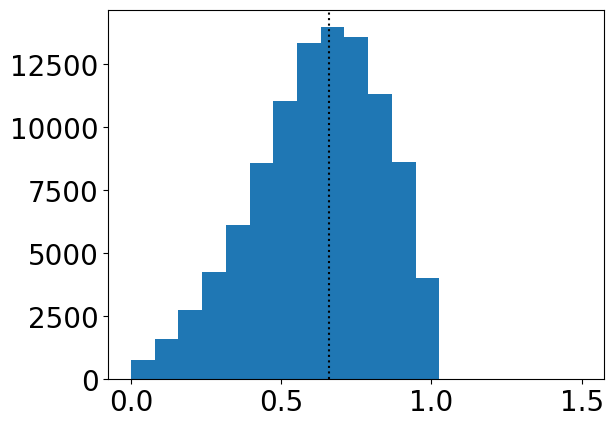

In [3]:
plt.hist(r_true,bins=np.linspace(0,1.5,20))
plt.axvline(0.66,color="black",ls=":")

## Set up the binning 

Goal is to learn average value of the four jet substructure observables as a function of jet pT.

In [4]:
#For the binning, make it so we have 50% in each bin growing from the low side
binvals = [100]
i = 0
while binvals[-1] < 500:
    for binhigh in range(binvals[i]+1,1000):
        purity = len(pT_true[(pT_true > binvals[i])*(pT_true < binhigh)*(pT_reco > binvals[i])*(pT_reco < binhigh)]) / len(pT_true[(pT_true > binvals[i])*(pT_true < binhigh)])
        if (purity > 0.5**0.5):
            print(binhigh,purity)
            i+=1
            binvals+=[binhigh]
            break

135 0.71206038220652
177 0.7091385722124002
227 0.7111022560078469
288 0.7099218376136545
363 0.708966365153245
459 0.708138048572646
581 0.7089120370370371


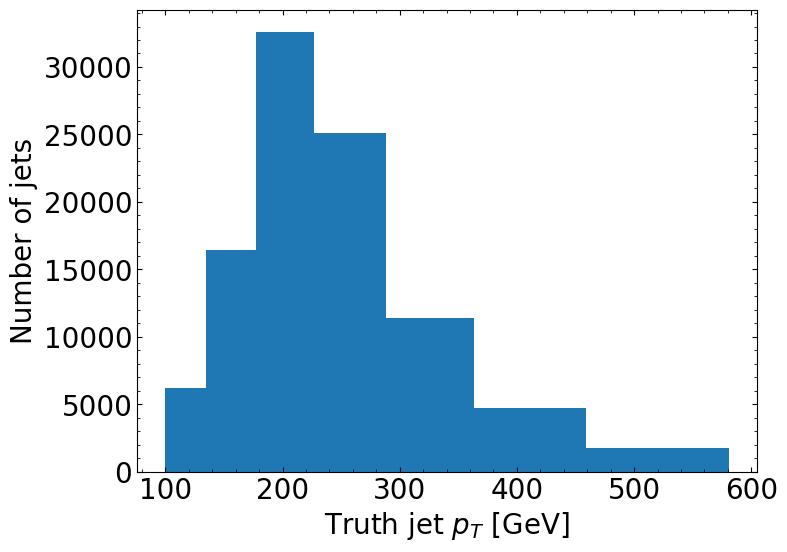

In [5]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

n,b,_=plt.hist(pT_true,bins=binvals)
plt.xlabel("Truth jet $p_T$ [GeV]")
plt.ylabel("Number of jets")
fig.savefig('figures/jetpt.pdf',bbox_inches='tight')

For the binned comparison, we pick the largest bins that have 50% purity.

In [6]:
#Next, let's construct the response matrix.

pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1

#alt

pTbin_truth_alt = np.clip(np.digitize(pT_true_alt,binvals),1,len(binvals)-1)-1
pTbin_reco_alt = np.clip(np.digitize(pT_reco_alt,binvals),1,len(binvals)-1)-1

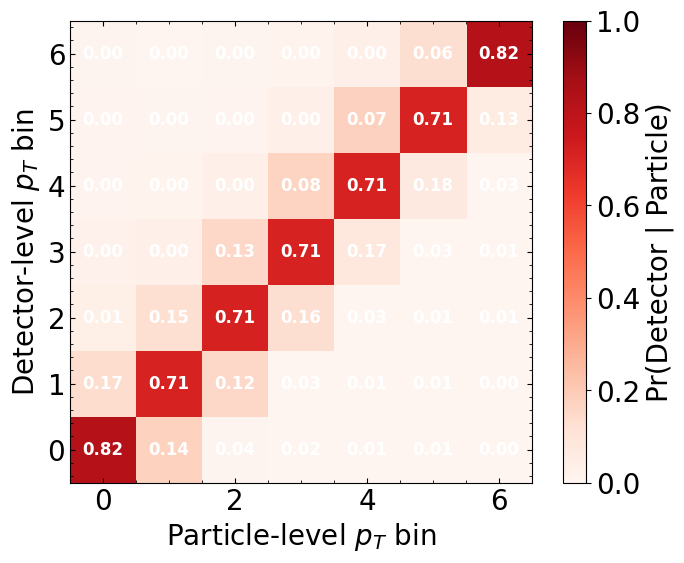

In [7]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
H_pT, xedges, yedges = np.histogram2d(pTbin_truth,pTbin_reco,bins=[range(len(binvals)),range(len(binvals))])
H_norm_pT = H_pT / H_pT.sum(axis=1, keepdims=True)
plt.imshow(H_norm_pT,origin='lower',cmap="Reds",vmin = 0,vmax = 1)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Pr(Detector | Particle)') 
plt.xlabel("Particle-level $p_{T}$ bin",fontsize=20)
plt.ylabel("Detector-level $p_{T}$ bin",fontsize=20)

for i in range(len(binvals)-1):
    for j2 in range(len(binvals)-1):
        plt.text(j2,i, "%0.2f" % H_norm_pT.T[i,j2], 
                color="w", ha="center", va="center", fontweight="bold",fontsize=12)
fig.savefig('figures/RsponsepT.pdf',bbox_inches='tight')

## Unfold

In [8]:
def IBU(T,D,R,n):
    phis = [T]
    for i in range(n):
        m = R * phis[-1]
        m /= (m.sum(axis=1)[:,np.newaxis] + 10**-50)
        phis.append(np.dot(m.T, D))
    return phis[-1]

In [9]:
T = np.sum(H_pT,axis=1)
D = np.sum(H_pT,axis=0)
IBU(T,D,H_norm_pT.T,1)

array([ 7312., 16403., 32624., 25076., 11387.,  4694.,  2504.])

In [10]:
T

array([ 7312., 16403., 32624., 25076., 11387.,  4694.,  2504.])

## OmniFold

(can skip past this part if you are only testing the Moment Unfolding parts, as this section takes some time to run)

In [11]:
from unfold import *

import os
os.environ['CUDA_VISIBLE_DEVICES']="1"

import tensorflow as tf
import tensorflow.keras.backend as K
tf.random.set_seed(1234)
np.random.seed(1234)

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
iterations = 5
dims = 2

In [13]:
#Poor-persons standardization

print(np.mean(pT_true/100-2))
print(np.std(pT_true/100-2))

print(np.mean(m_true/10-2))
print(np.std(m_true/10-2))

0.3352479021781921
0.8969343932954449
0.06362917586684212
1.0406744523929667


In [14]:
weights, models, history = multifold(dims, iterations, np.c_[pT_true/100.-2,m_true/10.-2], np.c_[pT_reco/100.-2,m_reco/10.-2], np.c_[pT_reco_alt/100.-2,m_reco_alt/10.-2], verbose=1)

ITERATION: 1
STEP 1...
Epoch 1/1000


2024-05-23 11:48:24.441836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13788 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
I0000 00:00:1716490105.425554 3977106 service.cc:145] XLA service 0x7f4324005ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716490105.425589 3977106 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-23 11:48:25.452216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 11:48:26.666202: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


182/750 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.4726 - loss: 0.6886

I0000 00:00:1716490107.860532 3977106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4910 - loss: 0.6865 - val_accuracy: 0.4859 - val_loss: 0.6843
Epoch 2/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5011 - loss: 0.6852 - val_accuracy: 0.4923 - val_loss: 0.6841
Epoch 3/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5002 - loss: 0.6850 - val_accuracy: 0.4914 - val_loss: 0.6841
Epoch 4/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5019 - loss: 0.6849 - val_accuracy: 0.5003 - val_loss: 0.6840
Epoch 5/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5067 - loss: 0.6848 - val_accuracy: 0.5012 - val_loss: 0.6840
Epoch 6/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5086 - loss: 0.6849 - val_accuracy: 0.4993 - val_loss: 0.6839
Epoch 7/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5057 - loss: 0.6848 - val_accuracy: 0.4962 - val_loss: 0.6839
Epoch 8/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5048 - loss: 0.6847 - val_accuracy:

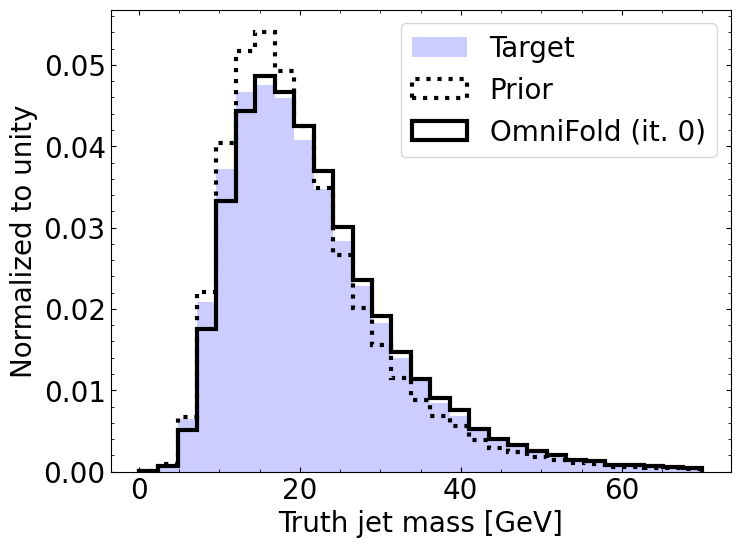

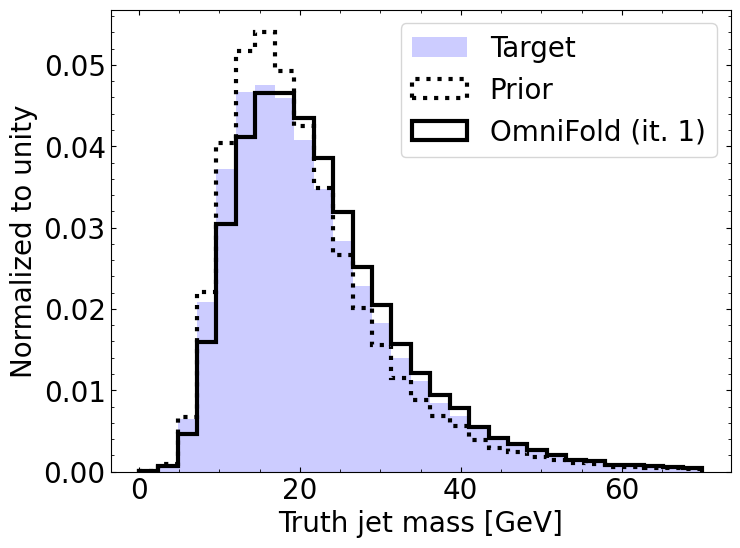

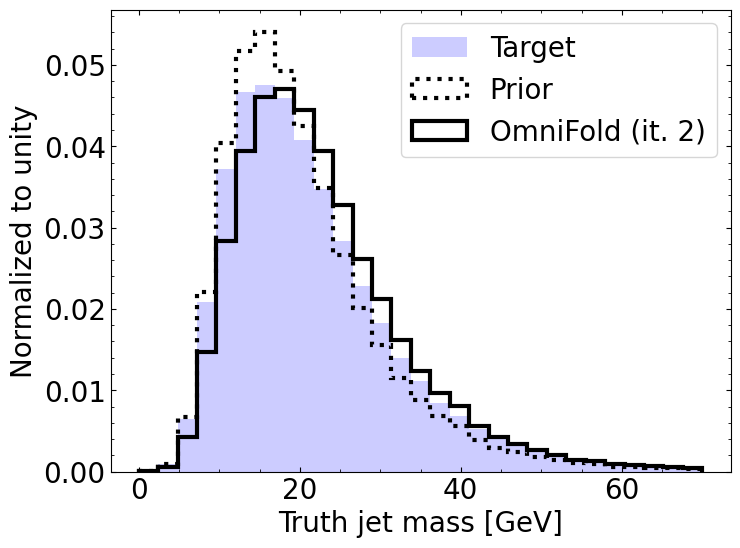

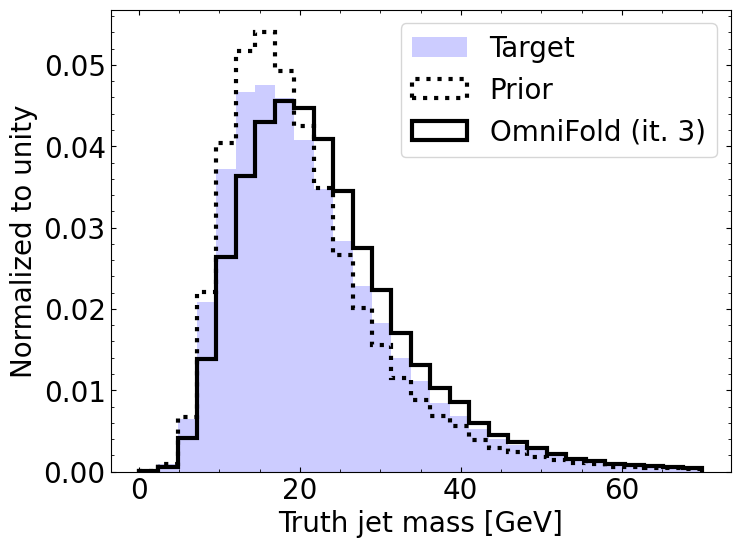

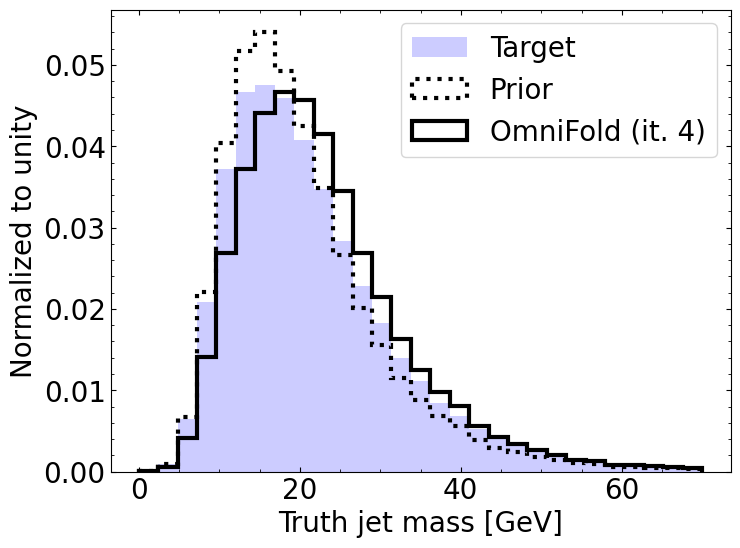

In [15]:
for i in range(iterations):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    OF,_,_  = plt.hist(m_true_alt,bins=np.linspace(0,70,30),color="blue",label="Target",density=True,alpha=0.2)
    T,_,_  = plt.hist(m_true,bins=np.linspace(0,70,30),ls=":",histtype="step",color="black",lw=3,label="Prior",density=True)
    G,_,_ = plt.hist(m_true,weights=weights[i,1],bins=np.linspace(0,70,30),lw=3,histtype="step",ls="-",color="black",label="OmniFold (it. "+str(i)+")",density=True)
    plt.legend()
    plt.xlabel("Truth jet mass [GeV]")
    plt.ylabel("Normalized to unity")

    fig.savefig('figures/OmniFold_iteration_'+str(i)+'.pdf',bbox_inches='tight')

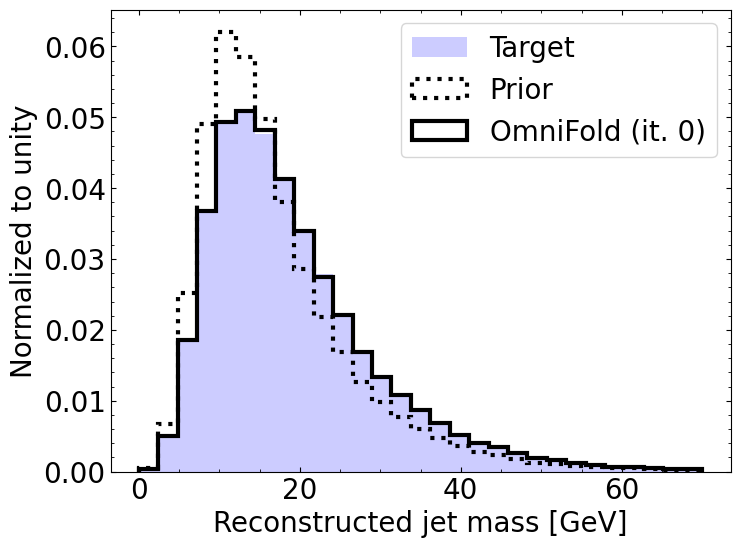

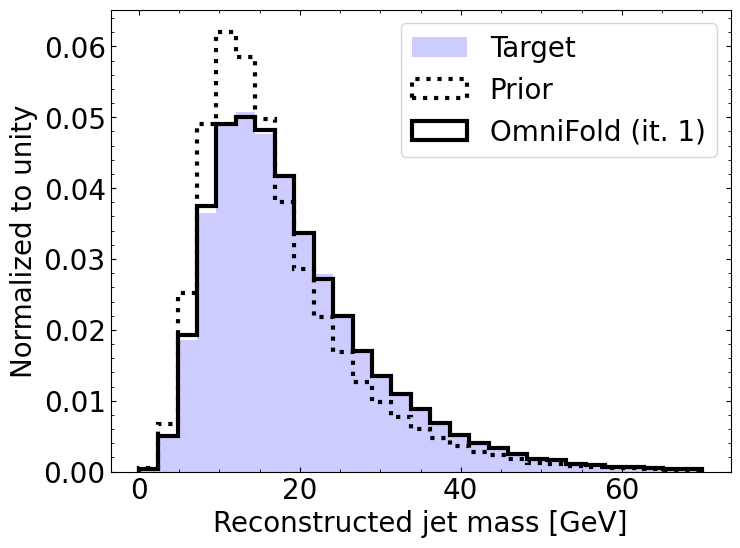

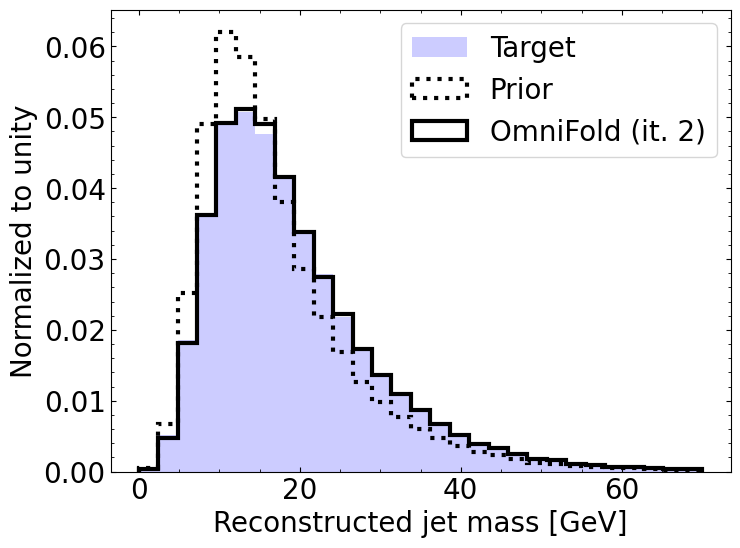

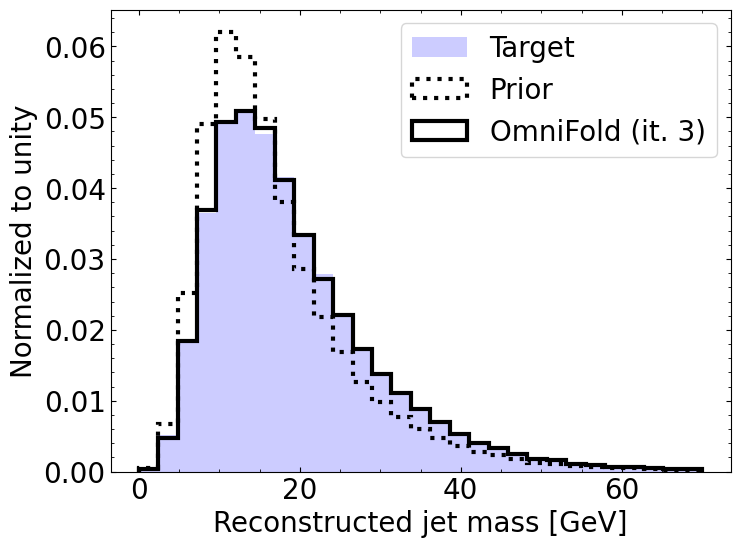

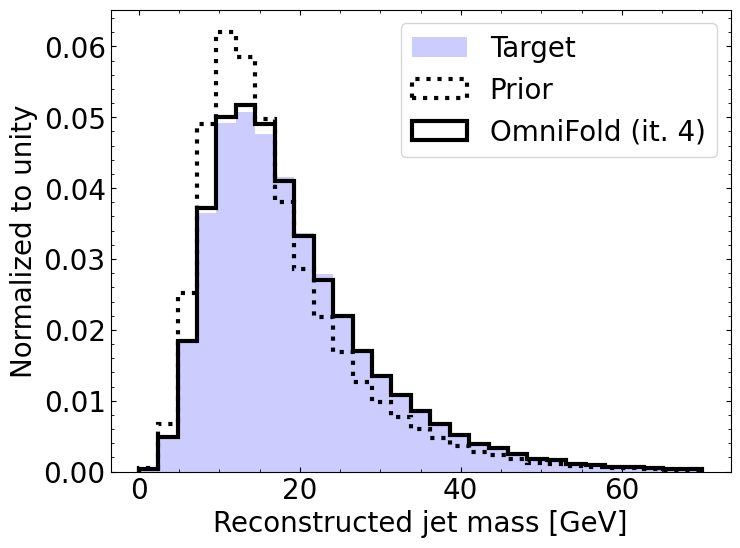

In [16]:
for i in range(iterations):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    OF,_,_  = plt.hist(m_reco_alt,bins=np.linspace(0,70,30),color="blue",label="Target",density=True,alpha=0.2)
    T,_,_  = plt.hist(m_reco,bins=np.linspace(0,70,30),ls=":",histtype="step",color="black",lw=3,label="Prior",density=True)
    G,_,_ = plt.hist(m_reco,weights=weights[i,0],bins=np.linspace(0,70,30),lw=3,histtype="step",ls="-",color="black",label="OmniFold (it. "+str(i)+")",density=True)
    plt.legend()
    plt.xlabel("Reconstructed jet mass [GeV]")
    plt.ylabel("Normalized to unity")

    fig.savefig('figures/OmniFold_iteration_'+str(i)+'_reco.pdf',bbox_inches='tight')

Text(0.5, 0, 'detector-level jet mass')

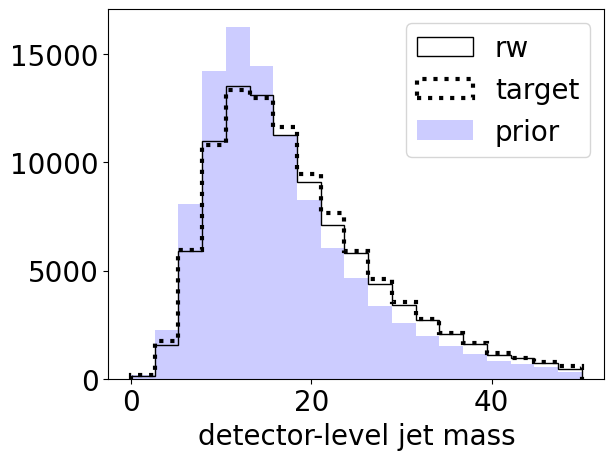

In [17]:
plt.hist(m_reco,weights=weights[-1,1],bins=np.linspace(0,50,20),histtype="step",ls="-",color="black",label="rw")
plt.hist(m_reco_alt,bins=np.linspace(0,50,20),ls=":",histtype="step",color="black",lw=3,label="target")
plt.hist(m_reco,bins=np.linspace(0,50,20),alpha=0.2,color="blue",label="prior")
plt.legend()
plt.xlabel("detector-level jet mass")

Text(0.5, 0, 'detector-level jet mass')

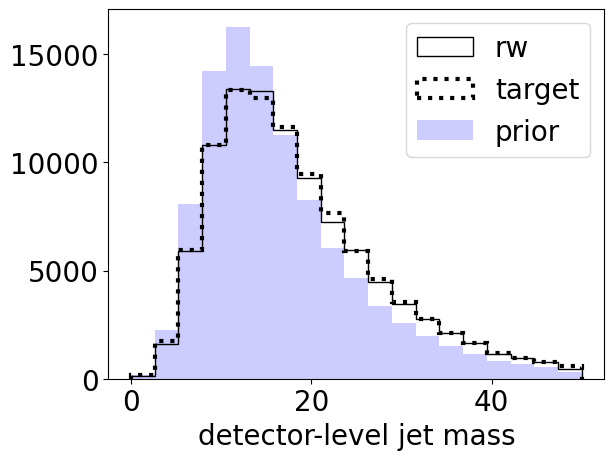

In [18]:
plt.hist(m_reco,weights=weights[-1,0],bins=np.linspace(0,50,20),histtype="step",ls="-",color="black",label="rw")
plt.hist(m_reco_alt,bins=np.linspace(0,50,20),ls=":",histtype="step",color="black",lw=3,label="target")
plt.hist(m_reco,bins=np.linspace(0,50,20),alpha=0.2,color="blue",label="prior")
plt.legend()
plt.xlabel("detector-level jet mass")

In [19]:
#poor-person standardization

print(np.mean(w_true*10-1))
print(np.std(w_true*10-1))

0.22261539439130448
0.9396588717880366


In [20]:
weightsW, modelsW, historyW = multifold(dims, iterations, np.c_[pT_true/100.-2,w_true*10.-1], np.c_[pT_reco/100.-2,w_reco*10.-1], np.c_[pT_reco_alt/100.-2,w_reco_alt*10.-1], verbose=1)

ITERATION: 1
STEP 1...
Epoch 1/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5229 - loss: 0.6848 - val_accuracy: 0.5368 - val_loss: 0.6826
Epoch 2/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5296 - loss: 0.6836 - val_accuracy: 0.5442 - val_loss: 0.6826
Epoch 3/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5295 - loss: 0.6836 - val_accuracy: 0.5441 - val_loss: 0.6826
Epoch 4/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5288 - loss: 0.6835 - val_accuracy: 0.5407 - val_loss: 0.6826
Epoch 5/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5277 - loss: 0.6835 - val_accuracy: 0.5442 - val_loss: 0.6826
Epoch 6/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5277 - loss: 0.6835 - val_accuracy: 0.5436 - val_loss: 0.6825
Epoch 7/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5281 - loss: 0.6833 - val_accuracy: 0.5285 - val_loss: 0.6825
Epoch 8/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0

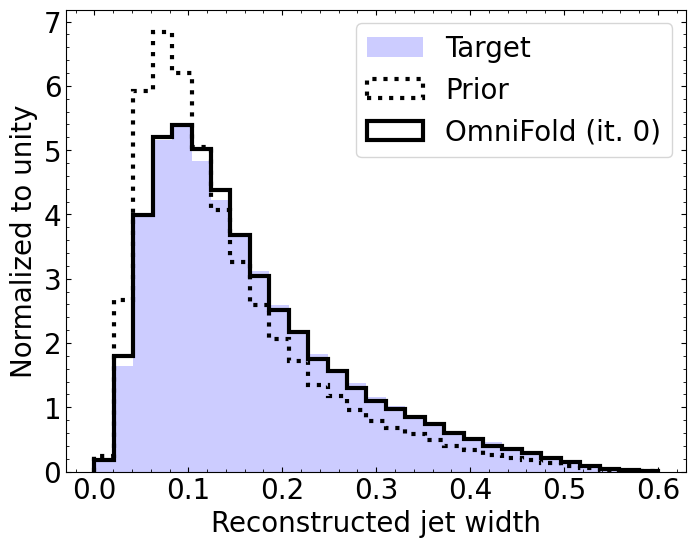

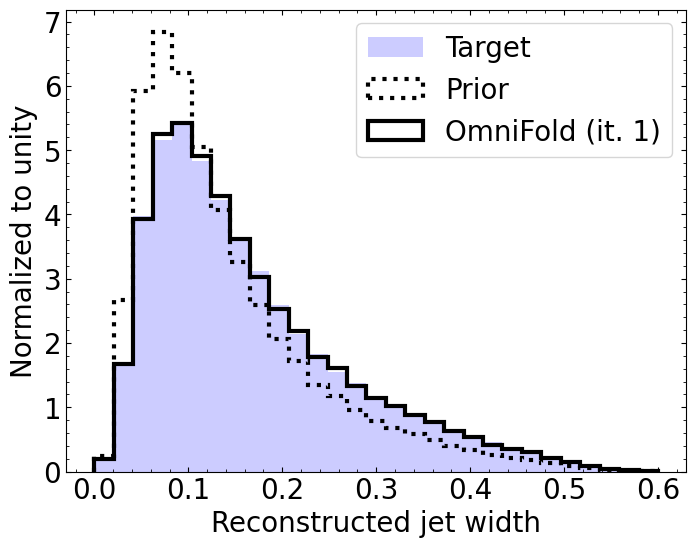

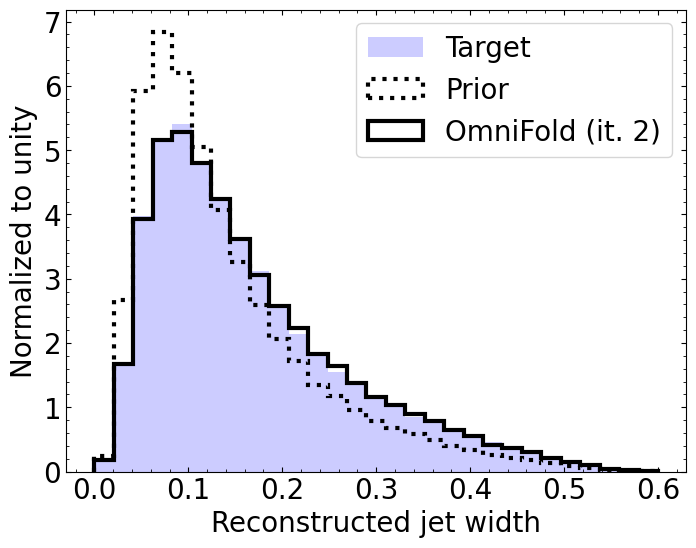

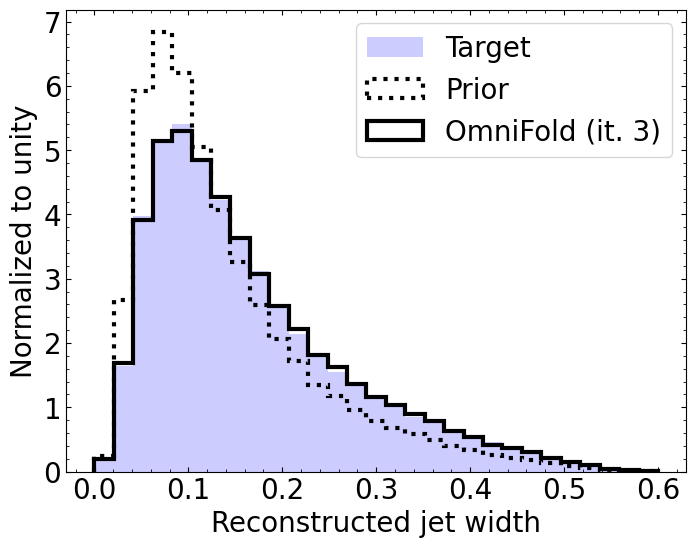

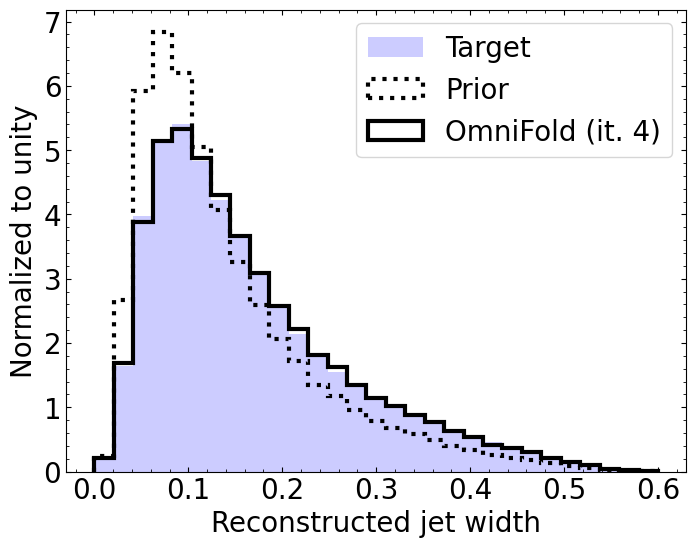

In [21]:
for i in range(iterations):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    OF,_,_  = plt.hist(w_reco_alt,bins=np.linspace(0,0.6,30),color="blue",label="Target",density=True,alpha=0.2)
    T,_,_  = plt.hist(w_reco,bins=np.linspace(0,0.6,30),ls=":",histtype="step",color="black",lw=3,label="Prior",density=True)
    G,_,_ = plt.hist(w_reco,weights=weightsW[i,0],bins=np.linspace(0,0.6,30),lw=3,histtype="step",ls="-",color="black",label="OmniFold (it. "+str(i)+")",density=True)
    plt.legend()
    plt.xlabel("Reconstructed jet width")
    plt.ylabel("Normalized to unity")

    fig.savefig('figures/OmniFoldW_iteration_'+str(i)+'_reco.pdf',bbox_inches='tight')

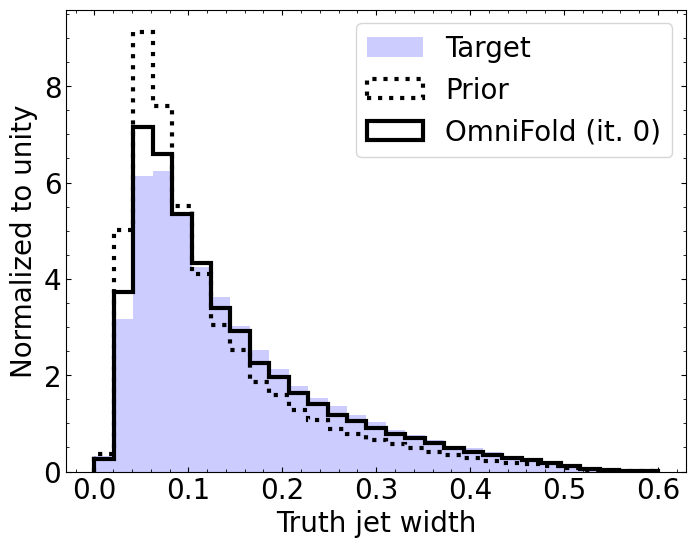

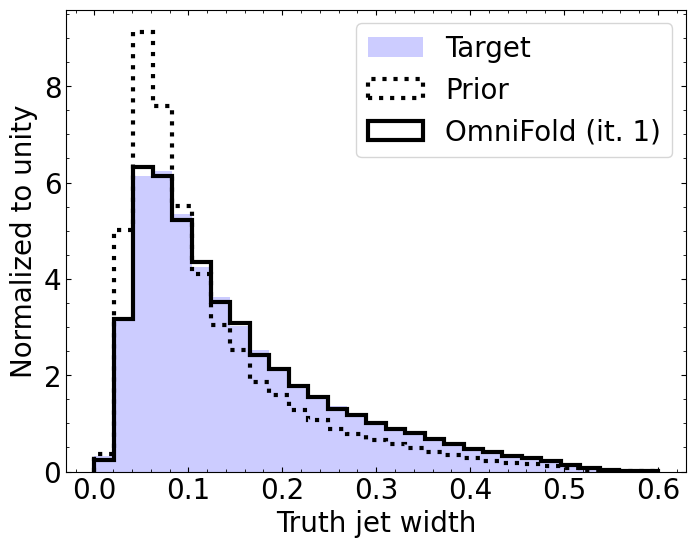

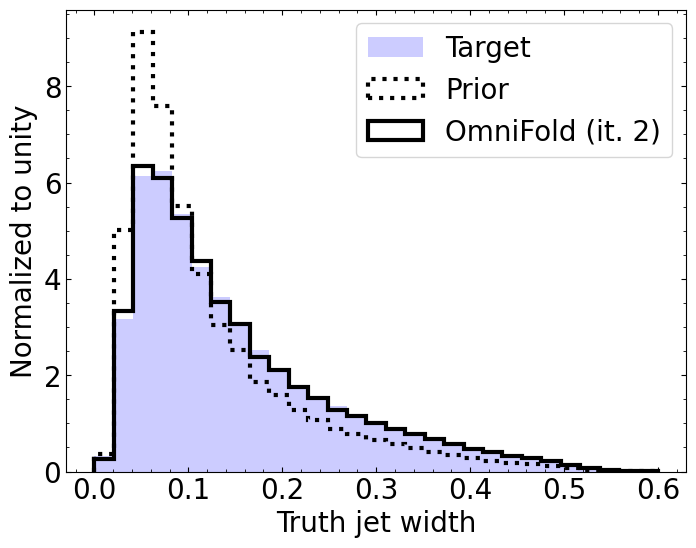

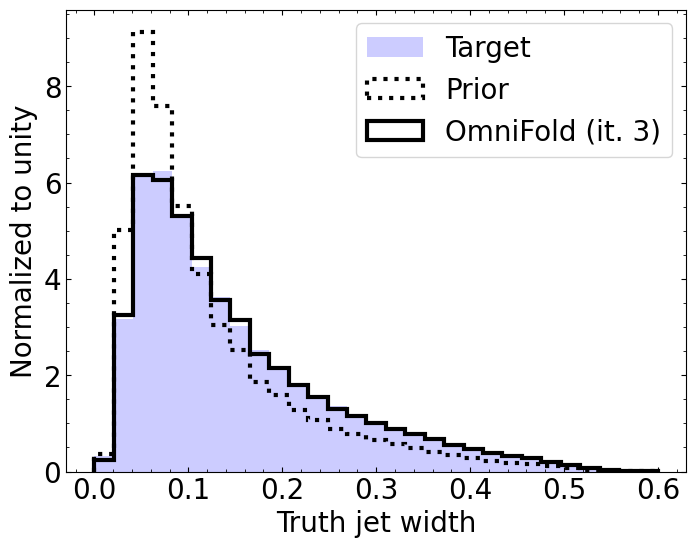

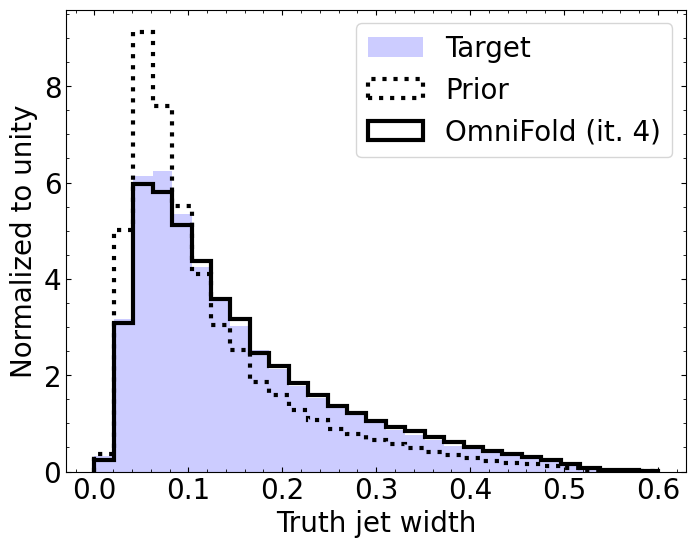

In [22]:
for i in range(iterations):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    OF,_,_  = plt.hist(w_true_alt,bins=np.linspace(0,0.6,30),color="blue",label="Target",density=True,alpha=0.2)
    T,_,_  = plt.hist(w_true,bins=np.linspace(0,0.6,30),ls=":",histtype="step",color="black",lw=3,label="Prior",density=True)
    G,_,_ = plt.hist(w_true,weights=weightsW[i,1],bins=np.linspace(0,0.6,30),lw=3,histtype="step",ls="-",color="black",label="OmniFold (it. "+str(i)+")",density=True)
    plt.legend()
    plt.xlabel("Truth jet width")
    plt.ylabel("Normalized to unity")

    fig.savefig('figures/OmniFoldW_iteration_'+str(i)+'.pdf',bbox_inches='tight')

Text(0.5, 0, 'jet width')

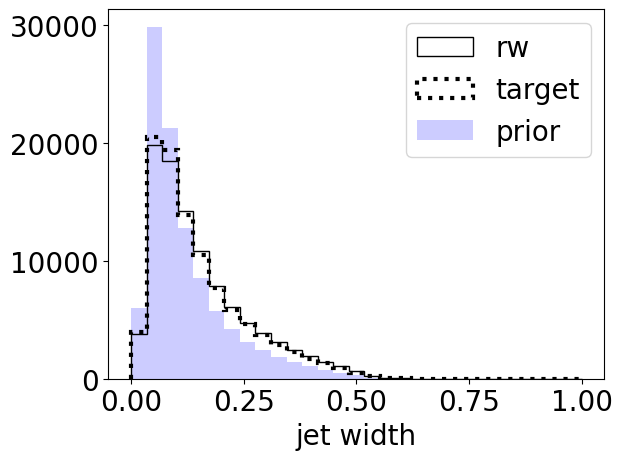

In [23]:
GW,_,_ = plt.hist(w_true,weights=weightsW[-1,1],bins=np.linspace(0,1,30),histtype="step",ls="-",color="black",label="rw")
OFW,_,_  = plt.hist(w_true_alt,bins=np.linspace(0,1,30),ls=":",histtype="step",color="black",lw=3,label="target")
TW,_,_  = plt.hist(w_true,bins=np.linspace(0,1,30),alpha=0.2,color="blue",label="prior")
plt.legend()
plt.xlabel("jet width")

In [24]:
#poor-person standardization

print(np.mean(np.array(q_true)*10))
print(np.std(np.array(q_true)*10))

print(np.mean(np.array(r_true)*5-3))
print(np.std(np.array(r_true)*5-3))

0.16244137851768065
1.2192546960235773
0.10817494338606026
1.0585531358692062


In [25]:
weightsQ, modelsQ, historyQ = multifold(dims, iterations, np.c_[pT_true/100.-2,q_true*10.], np.c_[pT_reco/100.-2,q_reco*10.], np.c_[pT_reco_alt/100.-2,q_reco_alt*10.], verbose=1)
weightsR, modelsR, historyR = multifold(dims, iterations, np.c_[pT_true/100.-2,r_true*5.-3], np.c_[pT_reco/100.-2,r_reco*5.-3], np.c_[pT_reco_alt/100.-2,r_reco_alt*5.-3], verbose=1)

ITERATION: 1
STEP 1...
Epoch 1/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5246 - loss: 0.6924 - val_accuracy: 0.5963 - val_loss: 0.6918
Epoch 2/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5760 - loss: 0.6919 - val_accuracy: 0.5784 - val_loss: 0.6918
Epoch 3/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5840 - loss: 0.6918 - val_accuracy: 0.5850 - val_loss: 0.6917
Epoch 4/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5838 - loss: 0.6917 - val_accuracy: 0.5752 - val_loss: 0.6918
Epoch 5/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5819 - loss: 0.6916 - val_accuracy: 0.5780 - val_loss: 0.6918
Epoch 6/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5795 - loss: 0.6917 - val_accuracy: 0.5631 - val_loss: 0.6918
Epoch 7/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5809 - loss: 0.6916 - val_accuracy: 0.5648 - val_loss: 0.6919
Epoch 8/1000
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0

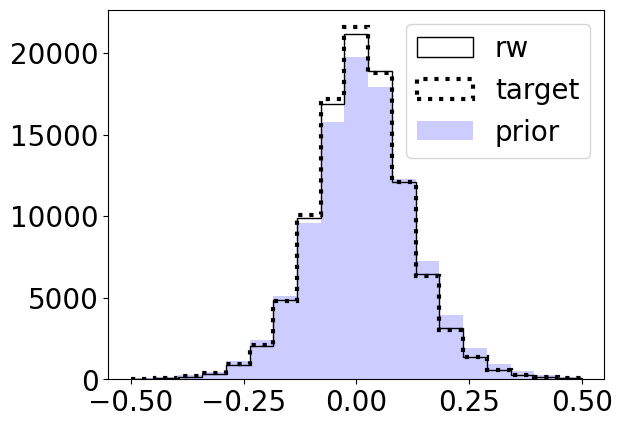

In [26]:
_,_,_ = plt.hist(q_true,weights=weightsQ[-1,1],bins=np.linspace(-0.5,0.5,20),histtype="step",ls="-",color="black",label="rw")
_,_,_  = plt.hist(q_true_alt,bins=np.linspace(-0.5,0.5,20),ls=":",histtype="step",color="black",lw=3,label="target")
_,_,_  = plt.hist(q_true,bins=np.linspace(-0.5,0.5,20),alpha=0.2,color="blue",label="prior")
plt.legend()

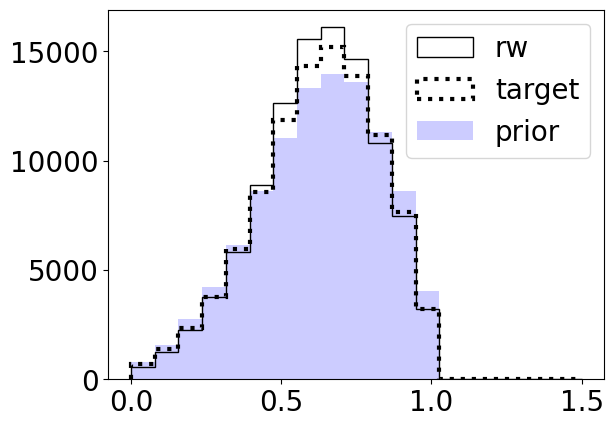

In [27]:
_,_,_ = plt.hist(r_true,weights=weightsR[-1,1],bins=np.linspace(0,1.5,20),histtype="step",ls="-",color="black",label="rw")
_,_,_  = plt.hist(r_true_alt,bins=np.linspace(0,1.5,20),ls=":",histtype="step",color="black",lw=3,label="target")
_,_,_  = plt.hist(r_true,bins=np.linspace(0,1.5,20),alpha=0.2,color="blue",label="prior")
plt.legend()

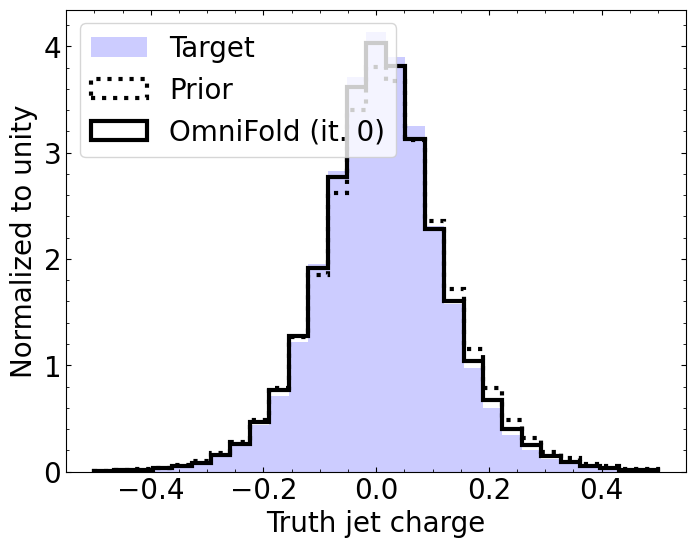

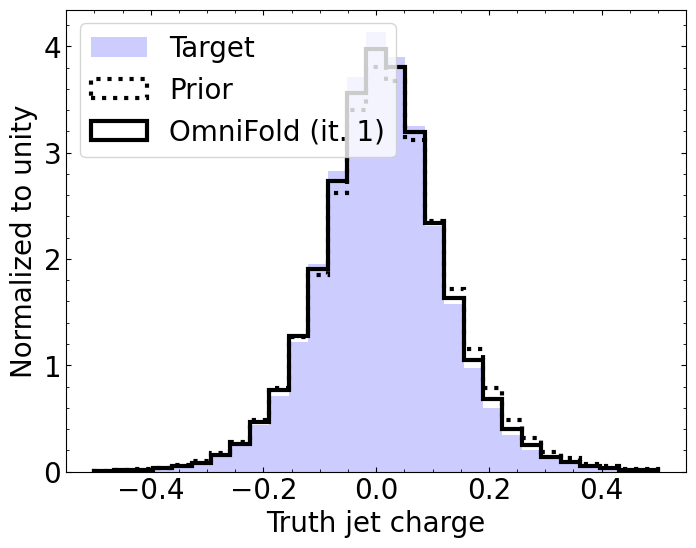

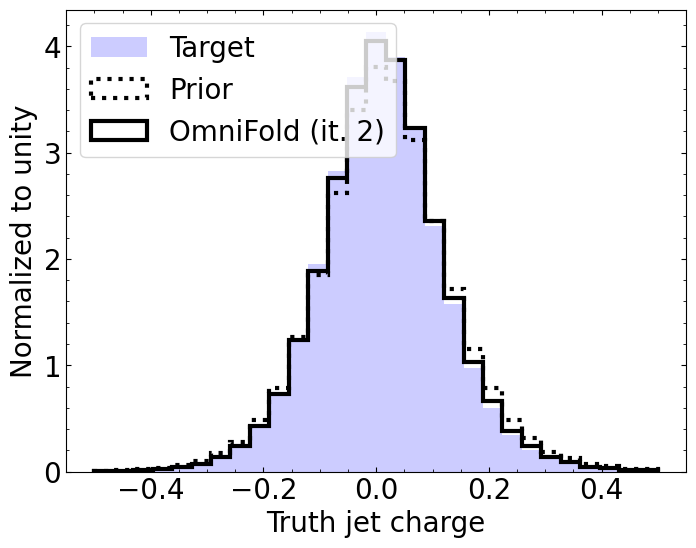

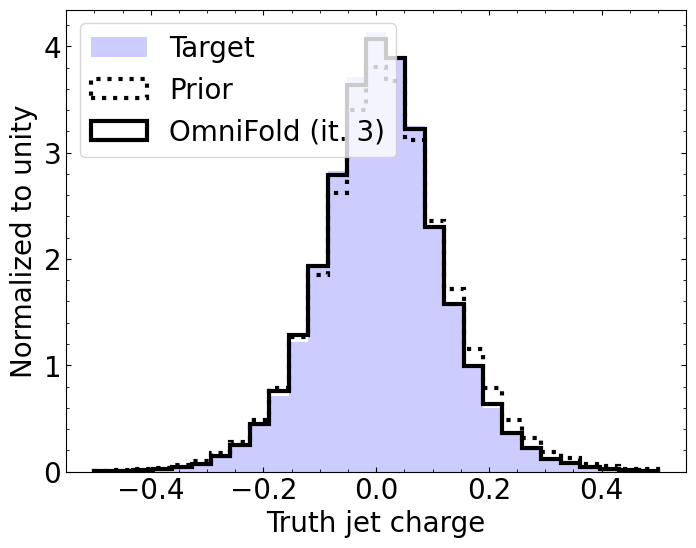

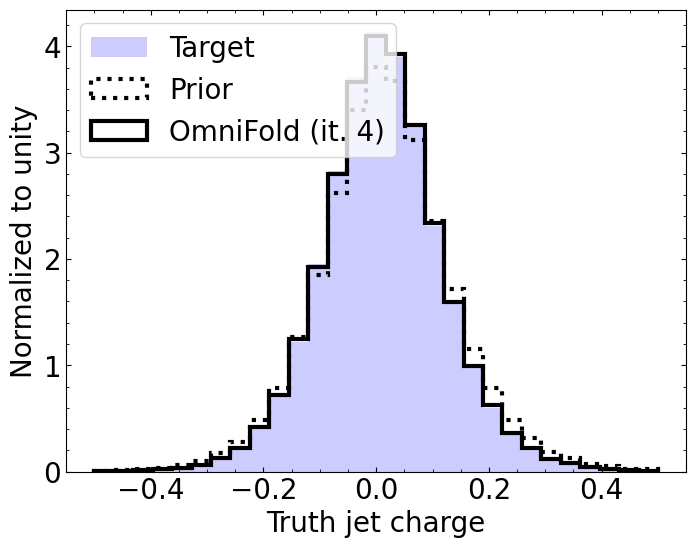

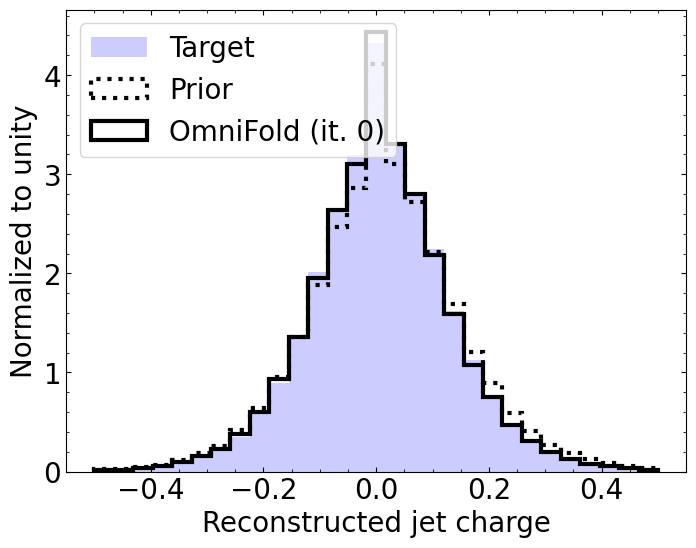

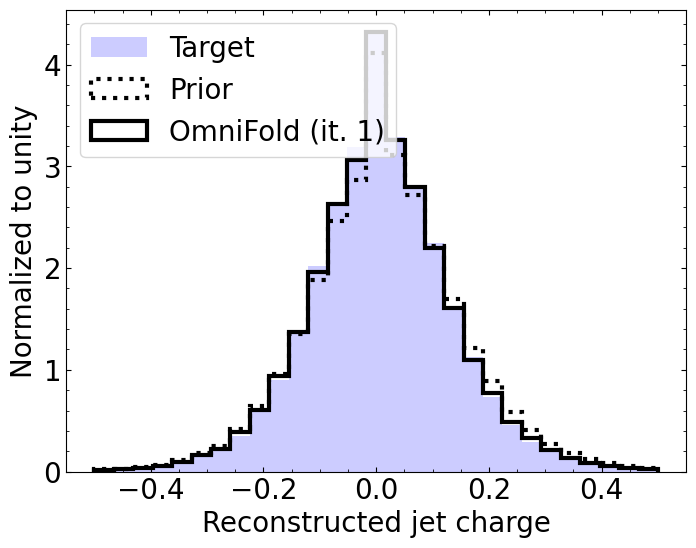

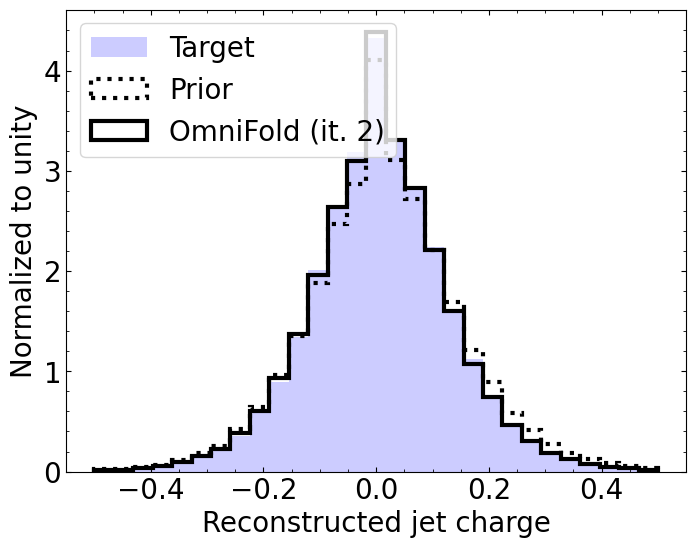

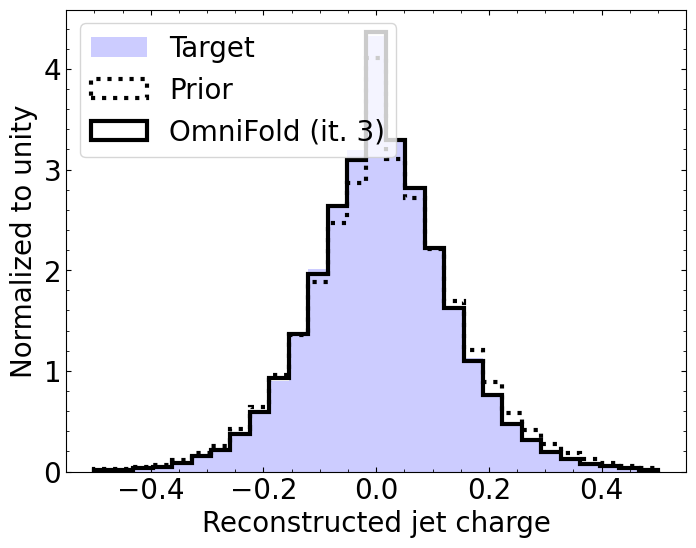

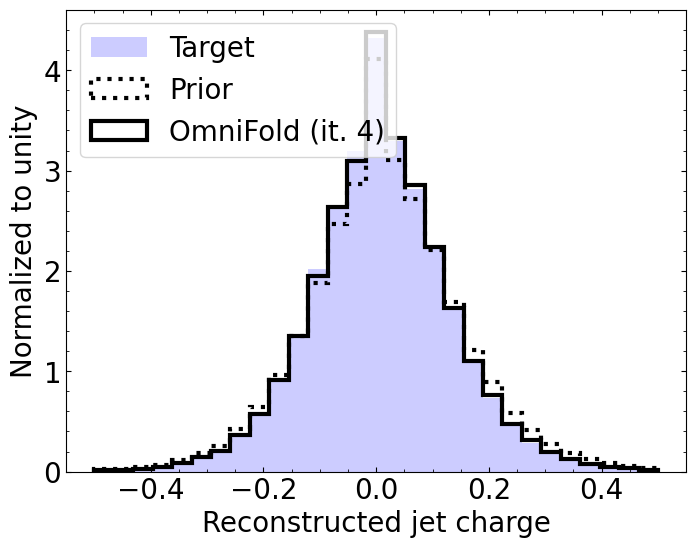

In [28]:
for i in range(iterations):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    OF,_,_  = plt.hist(q_true_alt,bins=np.linspace(-0.5,0.5,30),color="blue",label="Target",density=True,alpha=0.2)
    T,_,_  = plt.hist(q_true,bins=np.linspace(-0.5,0.5,30),ls=":",histtype="step",color="black",lw=3,label="Prior",density=True)
    G,_,_ = plt.hist(q_true,weights=weightsQ[i,1],bins=np.linspace(-0.5,0.5,30),lw=3,histtype="step",ls="-",color="black",label="OmniFold (it. "+str(i)+")",density=True)
    plt.legend()
    plt.xlabel("Truth jet charge")
    plt.ylabel("Normalized to unity")

    fig.savefig('figures/OmniFoldQ_iteration_'+str(i)+'.pdf',bbox_inches='tight')
    
for i in range(iterations):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    OF,_,_  = plt.hist(q_reco_alt,bins=np.linspace(-0.5,0.5,30),color="blue",label="Target",density=True,alpha=0.2)
    T,_,_  = plt.hist(q_reco,bins=np.linspace(-0.5,0.5,30),ls=":",histtype="step",color="black",lw=3,label="Prior",density=True)
    G,_,_ = plt.hist(q_reco,weights=weightsQ[i,0],bins=np.linspace(-0.5,0.5,30),lw=3,histtype="step",ls="-",color="black",label="OmniFold (it. "+str(i)+")",density=True)
    plt.legend()
    plt.xlabel("Reconstructed jet charge")
    plt.ylabel("Normalized to unity")

    fig.savefig('figures/OmniFoldQ_iteration_'+str(i)+'_reco.pdf',bbox_inches='tight')

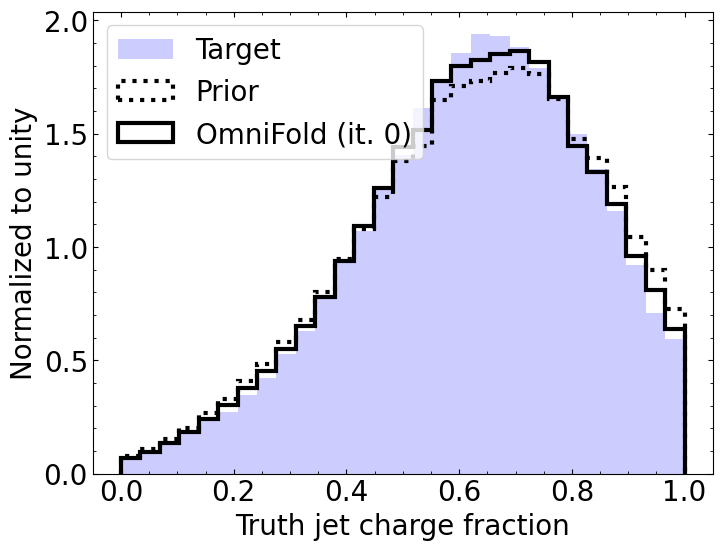

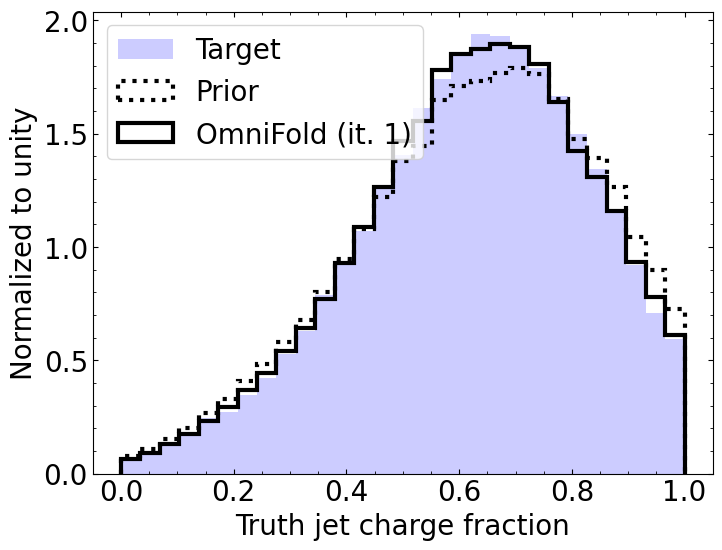

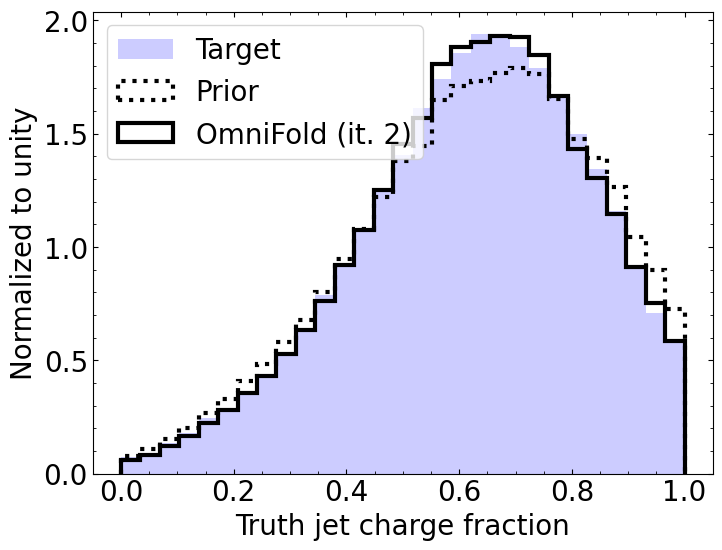

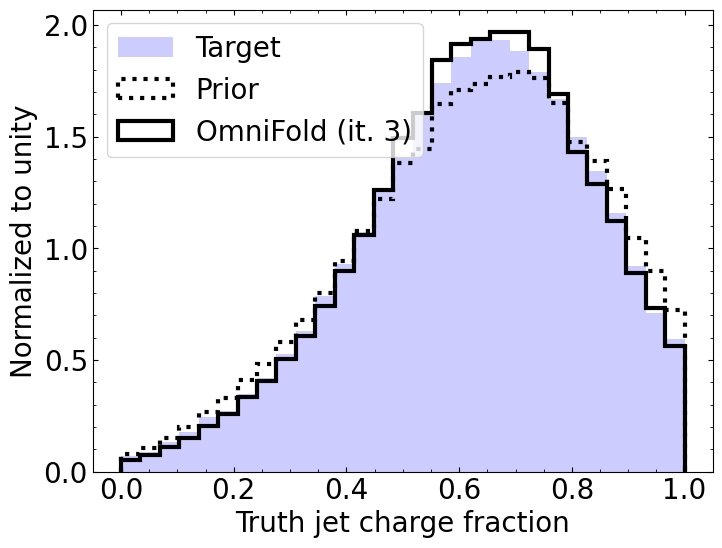

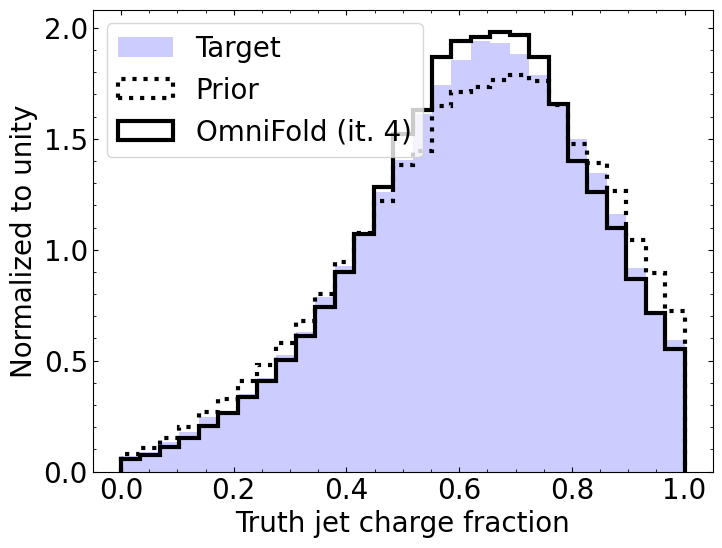

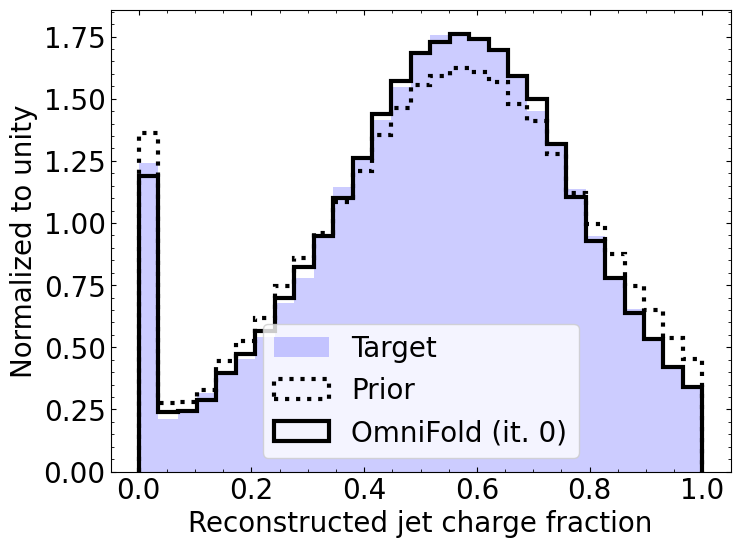

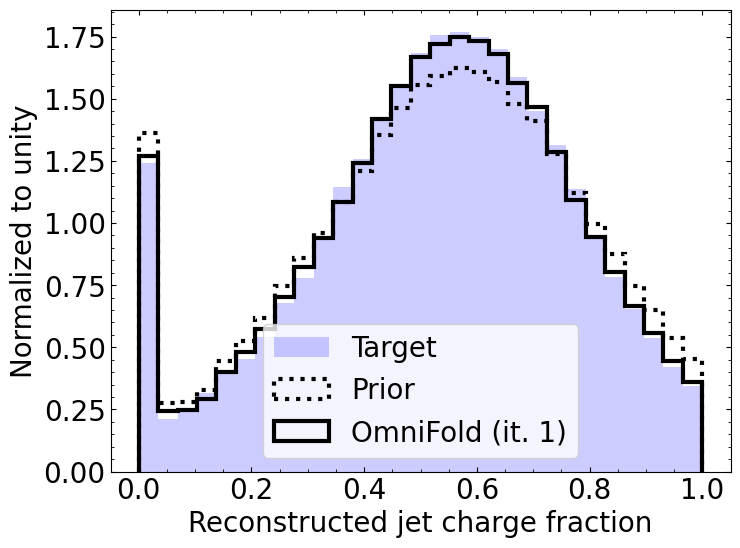

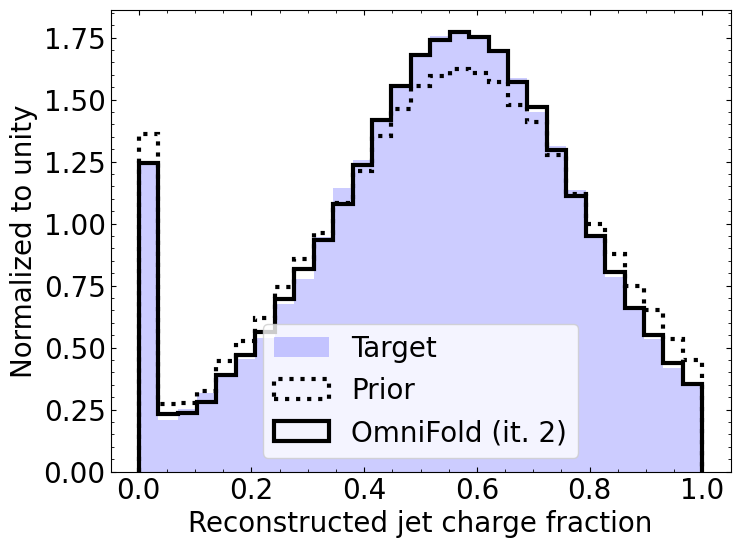

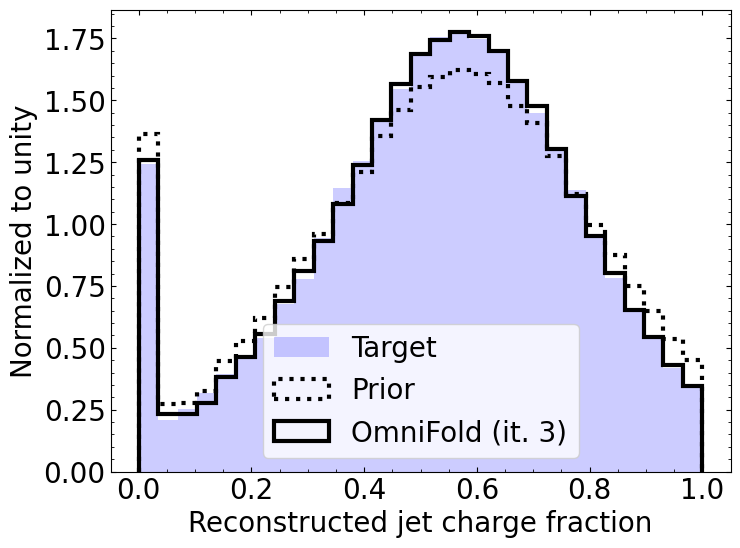

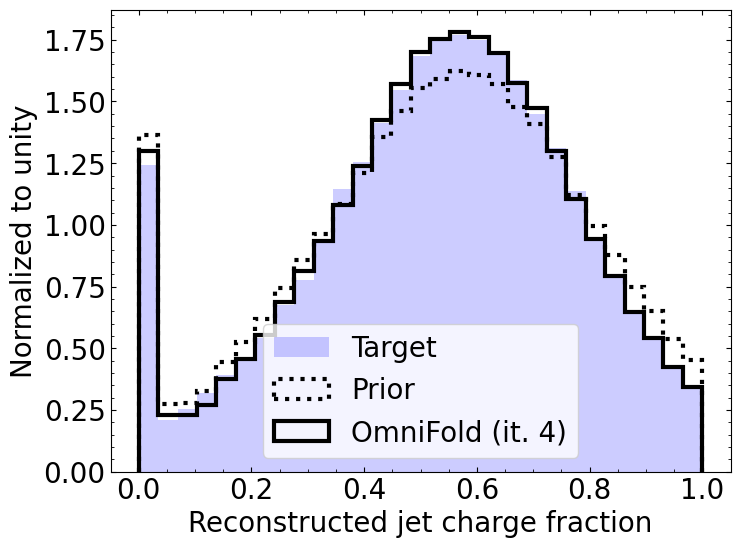

In [29]:
for i in range(iterations):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    OF,_,_  = plt.hist(r_true_alt,bins=np.linspace(0,1,30),color="blue",label="Target",density=True,alpha=0.2)
    T,_,_  = plt.hist(r_true,bins=np.linspace(0,1,30),ls=":",histtype="step",color="black",lw=3,label="Prior",density=True)
    G,_,_ = plt.hist(r_true,weights=weightsR[i,1],bins=np.linspace(0,1,30),lw=3,histtype="step",ls="-",color="black",label="OmniFold (it. "+str(i)+")",density=True)
    plt.legend()
    plt.xlabel("Truth jet charge fraction")
    plt.ylabel("Normalized to unity")

    fig.savefig('figures/OmniFoldR_iteration_'+str(i)+'.pdf',bbox_inches='tight')
    
for i in range(iterations):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    OF,_,_  = plt.hist(r_reco_alt,bins=np.linspace(0,1,30),color="blue",label="Target",density=True,alpha=0.2)
    T,_,_  = plt.hist(r_reco,bins=np.linspace(0,1,30),ls=":",histtype="step",color="black",lw=3,label="Prior",density=True)
    G,_,_ = plt.hist(r_reco,weights=weightsR[i,0],bins=np.linspace(0,1,30),lw=3,histtype="step",ls="-",color="black",label="OmniFold (it. "+str(i)+")",density=True)
    plt.legend()
    plt.xlabel("Reconstructed jet charge fraction")
    plt.ylabel("Normalized to unity")

    fig.savefig('figures/OmniFoldR_iteration_'+str(i)+'_reco.pdf',bbox_inches='tight')

In [31]:
datasets = {"Pythia26": np.load("/global/home/users/krishdesai/.energyflow/datasets/ZjetsDelphes/Pythia26_Zjet_pTZ-200GeV_0.npz"),
            "Herwig": np.load("/global/home/users/krishdesai/.energyflow/datasets/ZjetsDelphes/Herwig_Zjet_pTZ-200GeV_0.npz")
           }

In [32]:
pT_true = datasets['Pythia26']['gen_jets'][:,0]
pT_reco = datasets['Pythia26']['sim_jets'][:,0]

pT_true_alt = datasets['Herwig']['gen_jets'][:,0]
pT_reco_alt = datasets['Herwig']['sim_jets'][:,0]

features = {}

features["m","rec","nom"] = np.array(datasets['Pythia26']['sim_jets'][:,3])
features["m","tru","nom"] = np.array(datasets['Pythia26']['gen_jets'][:,3])
features["m","rec","alt"] = np.array(datasets['Herwig']['sim_jets'][:,3])
features["m","tru","alt"] = np.array(datasets['Herwig']['gen_jets'][:,3])

features["w","rec","nom"] = np.array(datasets['Pythia26']['sim_widths'])
features["w","tru","nom"] = np.array(datasets['Pythia26']['gen_widths'])
features["w","rec","alt"] = np.array(datasets['Herwig']['sim_widths'])
features["w","tru","alt"] = np.array(datasets['Herwig']['gen_widths'])

features["q","rec","nom"] = q_reco[:pT_true.shape[0]]
features["q","tru","nom"] = q_true[:pT_true.shape[0]]
features["q","rec","alt"] = q_reco_alt[:pT_true.shape[0]]
features["q","tru","alt"] = q_true_alt[:pT_true.shape[0]]

features["r","rec","nom"] = r_reco[:pT_true.shape[0]]
features["r","tru","nom"] = r_true[:pT_true.shape[0]]
features["r","rec","alt"] = r_reco_alt[:pT_true.shape[0]]
features["r","tru","alt"] = r_true_alt[:pT_true.shape[0]]

maxvalues = {}

maxvalues['m'] = 200
maxvalues['w'] = 0.7
maxvalues['q'] = 0.5
maxvalues['r'] = 1

minvalues = {}

minvalues['m'] = 0
minvalues['w'] = 0
minvalues['q'] = -0.5
minvalues['r'] = 0

omnifolded = {}
omnifolded['r'] = weightsR[-1,1]
omnifolded['q'] = weightsQ[-1,1]
omnifolded['w'] = weightsW[-1,1]
omnifolded['m'] = weights[-1,1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


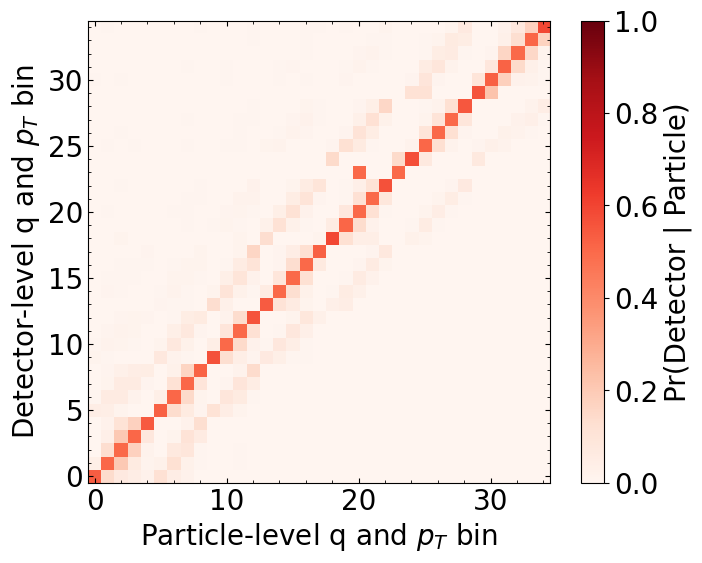

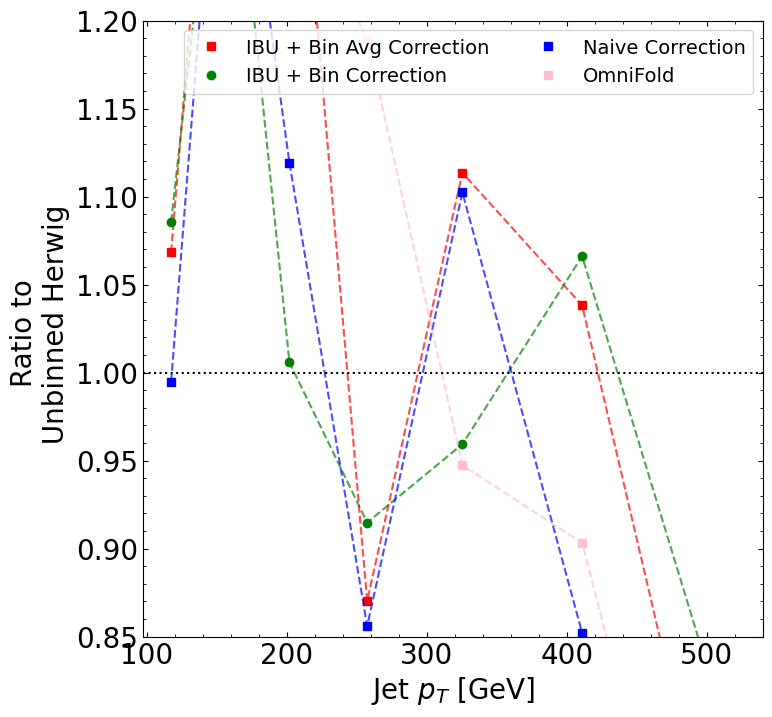

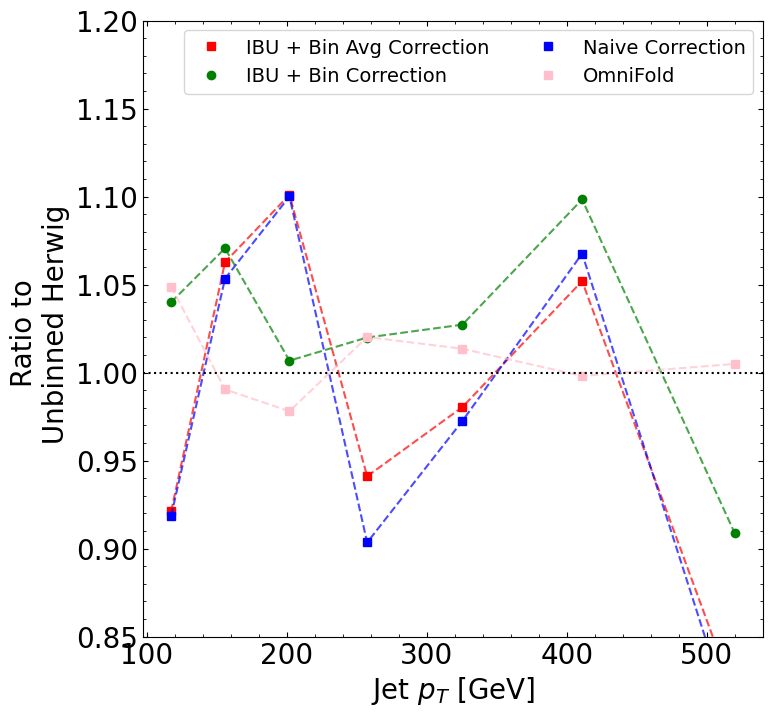

In [41]:
binvalsObs = {}
for obs in ['q']:
    binvalsObs[obs] = {}
    pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
    pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1
    xt = features[obs,"tru","nom"]
    xr = features[obs,"rec","nom"]
    for ii in range(len(binvals)-1):
        binvalsObs[obs][ii] = [minvalues[obs]]
        i = 0
        disttotal = 0.
        breakloop = True
        while len(binvalsObs[obs][ii]) < 15 and binvalsObs[obs][ii][-1] < maxvalues[obs] and breakloop:
            mycount = 0
            for binhigh in np.linspace(binvalsObs[obs][ii][i]+0.01,maxvalues[obs],100):
                mycount+=1
                purity = len(xt[(pTbin_reco==ii)*(pTbin_truth==ii)*(xt > binvalsObs[obs][ii][i])*(xt < binhigh)*(xr > binvalsObs[obs][ii][i])*(xr < binhigh)]) / (0.00000001+len(xt[(pTbin_truth==ii)*(xt > binvalsObs[obs][ii][i])*(xt < binhigh)]))
                distamount = len(xt[(pTbin_reco==ii)*(pTbin_truth==ii)*(xr > binvalsObs[obs][ii][i])*(xr < binhigh)]) / (0.00000001+len(xr[(pTbin_reco==ii)*(pTbin_truth==ii)]))
                if (purity > 0.5):
                    i+=1
                    disttotal += distamount
                    binvalsObs[obs][ii]+=[binhigh]
                    #print("  ",binhigh,purity,disttotal,distamount)
                    break
                if (mycount==99):
                    breakloop = False
                    #binvalsObs[obs][ii]+=[rmax]

        pass
    
    #Next, let's construct the response matrix.

    pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
    pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1

    xbin_truth_all = np.array([np.clip(np.digitize(xt,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)])
    xbin_reco_all = np.array([np.clip(np.digitize(xr,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)] )
    xbin_truth_all = xbin_truth_all.T
    xbin_reco_all = xbin_reco_all.T

    xbin_truth = np.array([xbin_truth_all[i][pTbin_truth[i]] for i in range(len(pTbin_truth))])
    xbin_reco = np.array([xbin_reco_all[i][pTbin_reco[i]] for i in range(len(pTbin_reco))])

    ###
    bin2_truth = []
    for i in range(len(pTbin_truth)):
        mybin = 0
        for i2 in range(0,pTbin_truth[i]):
            mybin+=len(binvalsObs[obs][i2])-1
        bin2_truth+=[mybin+xbin_truth[i]]

    bin2_reco = []
    for i in range(len(pTbin_reco)):
        mybin = 0
        for i2 in range(0,pTbin_reco[i]):
            mybin+=len(binvalsObs[obs][i2])-1
        bin2_reco+=[mybin+xbin_reco[i]]

    #alt
    xta = features[obs,"tru","alt"]
    xra = features[obs,"rec","alt"]

    pTbin_truth_alt = np.clip(np.digitize(pT_true_alt,binvals),1,len(binvals)-1)-1
    pTbin_reco_alt = np.clip(np.digitize(pT_reco_alt,binvals),1,len(binvals)-1)-1

    xbin_truth_all_alt = np.array([np.clip(np.digitize(xta,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)])
    xbin_reco_all_alt = np.array([np.clip(np.digitize(xra,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)] )
    xbin_truth_all_alt = xbin_truth_all_alt.T
    xbin_reco_all_alt = xbin_reco_all_alt.T

    xbin_truth_alt = np.array([xbin_truth_all_alt[i][pTbin_truth_alt[i]] for i in range(len(pTbin_truth_alt))])
    xbin_reco_alt = np.array([xbin_reco_all_alt[i][pTbin_reco_alt[i]] for i in range(len(pTbin_reco_alt))])

    bin2_truth_alt = []
    for i in range(len(pTbin_truth_alt)):
        mybin = 0
        for i2 in range(0,pTbin_truth_alt[i]):
            mybin+=len(binvalsObs[obs][i2])-1
        bin2_truth_alt+=[mybin+xbin_truth_alt[i]]

    bin2_reco_alt = []
    for i in range(len(pTbin_reco_alt)):
        mybin = 0
        for i2 in range(0,pTbin_reco_alt[i]):
            mybin+=len(binvalsObs[obs][i2])-1
        bin2_reco_alt+=[mybin+xbin_reco_alt[i]]

    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    H, xedges, yedges = np.histogram2d(bin2_truth,bin2_reco,bins=[range(max(bin2_truth)+2),range(max(bin2_truth)+2)])
    H_alt, xedges, yedges = np.histogram2d(bin2_truth_alt,bin2_reco_alt,bins=[range(max(bin2_truth)+2),range(max(bin2_truth)+2)])
    H_norm = H / H.sum(axis=1, keepdims=True)
    plt.imshow(H_norm,origin='lower',cmap="Reds",vmin = 0,vmax = 1)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Pr(Detector | Particle)')

    plt.xlabel("Particle-level "+obs+" and $p_{T}$ bin",fontsize=20)
    plt.ylabel("Detector-level "+obs+" and $p_{T}$ bin",fontsize=20)
    fig.savefig('figures/response'+obs+'.pdf',bbox_inches='tight')
    
    #IBU
    T = np.sum(H,axis=1)
    D = np.sum(H,axis=0)
    D_alt = np.sum(H_alt,axis=0)
    T_alt = np.sum(H_alt,axis=1)
    ibu = IBU(T,D_alt,H_norm.T,10)
    #ibu = IBU(T,D,H_norm.T,10)
    
    for moment in [1,2]:

        #Unbinned
        means_unbinnedx = np.array([np.mean(xt[pTbin_truth==i]**moment) for i in range(7)])
        means_unbinnedx_alt = np.array([np.mean(xta[pTbin_truth_alt==i]**moment) for i in range(7)])

        means_unbinnedx_reco = np.array([np.mean(xr[pTbin_reco==i]**moment) for i in range(7)])
        means_unbinnedx_reco_alt = np.array([np.mean(xra[pTbin_reco_alt==i]**moment) for i in range(7)])
        means_unbinnedx_omnifold_alt = np.array([np.average(xt[pTbin_truth==i]**moment,weights=omnifolded[obs][pTbin_truth==i]) for i in range(7)])

        #Various corrections
        means_binnedx = []
        means_binnedx_alt = []
        means_binnedx_alt_corrected = []
        for i in range(7):

            mybin = 0
            for i2 in range(0,i):
                mybin += len(binvalsObs[obs][i2])-1

            ibu_i = [ibu[mybin+j] for j in range(len(binvalsObs[obs][i])-1)]

            x_centers = 0.5*(np.array(binvalsObs[obs][i][0:-1])+np.array(binvalsObs[obs][i][1:]))
            xvals = [len(xt[(pTbin_truth==i)*(xbin_truth==j)]) for j in range(len(binvalsObs[obs][i])-1)]
            xvals_alt = [len(xta[(pTbin_truth_alt==i)*(xbin_truth_alt==j)]) for j in range(len(binvalsObs[obs][i])-1)]
            means_binnedx += [np.sum(x_centers**moment*xvals)/np.sum(xvals)]
            means_binnedx_alt += [np.sum(x_centers**moment*ibu_i)/np.sum(ibu_i)]

            #Try a per-bin correction
            xiavg = []
            for j in range(len(binvalsObs[obs][i])-1):
                xiavg+=[np.mean(xt[(pTbin_truth==i)*(xbin_truth==j)]**moment)]
            xiavg = np.array(xiavg)
            #print(np.mean(xt[(pTbin_truth==i)]),np.sum(xiavg*ibu_i)/np.sum(ibu_i))
            means_binnedx_alt_corrected += [np.sum(xiavg*ibu_i)/np.sum(ibu_i)]

        means_binnedx = np.array(means_binnedx)
        means_binnedx_alt = np.array(means_binnedx_alt)
        means_binnedx_alt_corrected = np.array(means_binnedx_alt_corrected)

        fig, ax1 = plt.subplots(figsize=(8, 8))

        plt.legend(frameon=True,fontsize=14)
        if (moment==1):
            plt.ylabel(r'$< '+obs+' >$',fontsize=20)
        else:
            plt.ylabel(r'$< '+obs+'^'+str(moment)+' >$',fontsize=20)
        if (obs=='m'):
            if (moment==1):
                plt.ylabel(r'$< '+obs+' >$ [GeV]',fontsize=20)
            else:
                plt.ylabel(r'$< '+obs+'^'+str(moment)+' >$ [GeV$^'+str(moment)+'$]',fontsize=20)
            
        ax1.yaxis.set_ticks_position('both')
        ax1.xaxis.set_ticks_position('both')
        ax1.tick_params(direction="in",which="both")
        ax1.minorticks_on()

        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),means_binnedx_alt_corrected/means_unbinnedx_alt,c = 'r', marker='s',ls="",label="IBU + Bin Avg Correction")
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),means_binnedx_alt_corrected/means_unbinnedx_alt,c = 'r', marker='',ls="--", alpha = 0.7)
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),(means_unbinnedx_reco_alt*means_unbinnedx/means_unbinnedx_reco)/means_unbinnedx_alt,marker='o',ls="",label="IBU + Bin Correction", c = 'g')
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),(means_unbinnedx_reco_alt*means_unbinnedx/means_unbinnedx_reco)/means_unbinnedx_alt,marker='',ls="--", alpha = 0.7, c = 'g')
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),(means_binnedx_alt*means_unbinnedx/means_binnedx)/means_unbinnedx_alt,c = 'b', marker='s',ls="",label="Naive Correction")
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),(means_binnedx_alt*means_unbinnedx/means_binnedx)/means_unbinnedx_alt,c = 'b', marker='',ls="--", alpha = 0.7)
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),means_unbinnedx_omnifold_alt/means_unbinnedx_alt, c = 'pink', marker='s',ls="",label="OmniFold")
        ax1.plot(0.5*(np.array(binvals[0:-1])+np.array(binvals[1:])),means_unbinnedx_omnifold_alt/means_unbinnedx_alt,c = 'pink', marker='',ls="--", alpha = 0.7)

        ax1.set_xlabel("Jet $p_{T}$ [GeV]",fontsize=20)
        ax1.axhline(1.,ls=":",color="black")
        ax1.set_ylim([0.85,1.2])
        ax1.legend(frameon=True,ncol=2,fontsize=14)
        plt.ylabel('Ratio to \n Unbinned Herwig',fontsize=20)
        fig.savefig('figures/moment'+str(moment)+"_"+obs+'_v_pT.pdf',bbox_inches='tight')

## Now, experiment with Moment OmniFolding

In [ ]:
gauss_data = np.random.normal(0,1,100000)
gauss_sim = np.random.normal(-0.5,1,100000)

In [ ]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    return K.mean(t_loss)

In [ ]:
losses = []
for lambda1 in np.linspace(-1,1,20):

    xvals_1 = np.concatenate([gauss_data,gauss_sim])
    yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])
    weights_1 = np.concatenate([np.ones(len(gauss_data)),np.exp(lambda1*gauss_sim)*len(gauss_data)/np.sum(np.exp(lambda1*gauss_sim))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    Y_train_2 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_2 = np.stack((Y_test_1, w_test_1), axis=1)

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_2,
              epochs=10,
              batch_size=1000,
              verbose=1)
    losses+=[model.history.history['loss'][-1]]

In [ ]:
lambda1 = 1

xvals_1 = np.concatenate([gauss_data,gauss_sim])
yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])
weights_1 = np.concatenate([np.ones(len(gauss_data)),np.exp(lambda1*gauss_sim)*len(gauss_data)/np.sum(np.exp(lambda1*gauss_sim))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

_,_,_=plt.hist(X_test_1[Y_test_1==1],bins=np.linspace(-4,4,20),alpha=0.5,label="data")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(-4,4,20),alpha=0.5,label="MC")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(-4,4,20),weights=w_test_1[Y_test_1==0],histtype="step",color="black",ls=":",label="weighted MC")
plt.legend(fontsize=15)
plt.ylim([0,8000])

In [ ]:
plt.plot(np.linspace(-1,1,20),losses)

In [ ]:
#GW,_,_ = plt.hist(w_true,weights=weightsW[-1,1],bins=np.linspace(0,1,30),histtype="step",ls="-",color="black",label="rw")
#OFW,_,_  = plt.hist(w_true_alt,bins=np.linspace(0,1,30),ls=":",histtype="step",color="black",lw=3,label="target")
#TW,_,_  = plt.hist(w_true,bins=np.linspace(0,1,30),alpha=0.2,color="blue",label="prior")
#plt.legend()
#plt.xlabel("jet width")

In [ ]:
losses_width = []
for lambda1 in np.linspace(-2,10,20):

    xvals_1 = np.concatenate([w_true_alt,w_true])
    yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    Y_train_2 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_2 = np.stack((Y_test_1, w_test_1), axis=1)

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_2,
              epochs=10,
              batch_size=1000,
              verbose=1)
    losses_width+=[model.history.history['loss'][-1]]

In [ ]:
losses_width2 = []
for lambda1 in np.linspace(-2,10,20):

    xvals_1 = np.concatenate([w_true_alt,w_true])
    yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true**2)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true**2))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    Y_train_2 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_2 = np.stack((Y_test_1, w_test_1), axis=1)

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_2,
              epochs=10,
              batch_size=1000,
              verbose=1)
    losses_width2+=[model.history.history['loss'][-1]]

In [ ]:
plt.plot(np.linspace(-2,10,20),losses_width)
plt.axvline(2.5)

In [ ]:
lambda1 = 2.5

xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

_,_,_=plt.hist(X_test_1[Y_test_1==1],bins=np.linspace(0,1,30),alpha=0.5,label="data")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(0,1,30),alpha=0.5,label="MC")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(0,1,30),weights=w_test_1[Y_test_1==0],histtype="step",color="black",ls=":",label="weighted MC")
plt.legend(fontsize=15)

In [ ]:
for lambda1 in np.linspace(-1,10,20):

    xvals_1 = np.concatenate([w_true_alt,w_true])
    yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    print(lambda1,np.mean(X_test_1[Y_test_1==1]),np.mean(X_test_1[Y_test_1==0]),np.average(X_test_1[Y_test_1==0],weights=w_test_1[Y_test_1==0]))

In [ ]:
for lambda1 in np.linspace(-1,10,20):

    xvals_1 = np.concatenate([w_true_alt,w_true])
    yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true**2)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true**2))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    print(lambda1,np.mean(X_test_1[Y_test_1==1]**2),np.mean(X_test_1[Y_test_1==0]**2),np.average(X_test_1[Y_test_1==0]**2,weights=w_test_1[Y_test_1==0]))

In [ ]:
losses_width = np.array(losses_width)
losses_width2 = np.array(losses_width2)
plt.plot(np.linspace(-2,10,20),losses_width)
plt.plot(np.linspace(-2,10,20),losses_width2)
plt.axvline(2.5,color="tab:blue",ls=":")
plt.axvline(4.5,color="tab:orange",ls=":")
plt.ylim([0.65,0.7])

## Try to do it in one step instead of scanning?

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import concatenate

initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._lambda0 = self.add_weight(name='lambda0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self._lambda1 = self.add_weight(name='lambda1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        #return tf.exp(self._lambda1 * x + self._lambda0)
        return tf.exp(self._lambda0 * x + self._lambda1 * x**2)

myc = 0.1
mymodel_inputtest = Input(shape=(1,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((1, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimantor = Model(inputs=inputs_disc, outputs=outputs_disc)

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

model_discrimantor.compile(loss=weighted_binary_crossentropy, optimizer='adam')

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)
    
model_discrimantor.trainable = False
mymodel_gan = Input(shape=(1,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimantor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer='adam')

In [ ]:
#xvals_1 = np.concatenate([gauss_data,gauss_sim])
#yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])

xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

n_epochs = 20
n_batch = 128*10
n_batches = len(X_train_1) // n_batch

for i in range(n_epochs):
    lambdasum = np.log(model_generator.predict([1.]))
    lambdasum2 = np.log(model_generator.predict([2.]))
    mylambda1 = (lambdasum2-2*lambdasum)/2
    mylambda0 = lambdasum - mylambda1
    print("on epoch=",i,mylambda0,mylambda1)
    #print("  ",np.sum(model_generator.predict(X_train_1,batch_size=1000)))
    for j in range(n_batches):
        X_batch = X_train_1[j*n_batch:(j+1)*n_batch]
        Y_batch = Y_train_1[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator(X_batch)
        W_batch = np.array(W_batch).flatten()
        W_batch[Y_batch==1] = 1
        #W_batch[Y_batch==0] = 1
        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        model_discrimantor.train_on_batch(X_batch, Y_batch_2)
        
        #print("      ",j,np.sum(model_generator.predict(X_batch,batch_size=1000)),np.log(model_generator.predict([1.]))-np.log(model_generator.predict([0.])),np.log(model_generator.predict([0.])))
        
        gan_model.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))

In [ ]:
lambda0 = 6.5
lambda1 = -9.3
xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true**2+lambda0*w_true)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true**2+lambda0*w_true))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

print(np.mean(X_test_1[Y_test_1==1]**2),np.mean(X_test_1[Y_test_1==0]**2),np.average(X_test_1[Y_test_1==0]**2,weights=w_test_1[Y_test_1==0]))
print(np.mean(X_test_1[Y_test_1==1]),np.mean(X_test_1[Y_test_1==0]),np.average(X_test_1[Y_test_1==0],weights=w_test_1[Y_test_1==0]))

## Now, try all moments at once

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
#mymodel_inputtest_unifold = Input(shape=(1,))
#hidden_layer_1_unifold = Dense(50, activation='LeakyReLU',use_bias=False)(mymodel_inputtest_unifold)
#batch_norm_1_unifold = BatchNormalization()(hidden_layer_1_unifold)
#hidden_layer_2_unifold = Dense(50, activation='LeakyReLU',use_bias=False)(batch_norm_1_unifold)
#batch_norm_2_unifold = BatchNormalization()(hidden_layer_2_unifold)
#hidden_layer_3_unifold = Dense(50, activation='LeakyReLU',use_bias=False)(batch_norm_2_unifold)
#outputs_unifold = Dense(1, activation='sigmoid',use_bias=False)(hidden_layer_3_unifold) #tanh
#model_generator_unifold = Model(mymodel_inputtest_unifold, outputs_unifold) #tf.exp(10*outputs_unifold))

mymodel_inputtest_unifold = Input(shape=(1,))
hidden_layer_1_unifold = Dense(50, activation='LeakyReLU',use_bias=True)(mymodel_inputtest_unifold)
batch_norm_1_unifold = BatchNormalization()(hidden_layer_1_unifold)
hidden_layer_2_unifold = Dense(50, activation='LeakyReLU',use_bias=True)(batch_norm_1_unifold)
batch_norm_2_unifold = BatchNormalization()(hidden_layer_2_unifold)
hidden_layer_3_unifold = Dense(50, activation='LeakyReLU',use_bias=True)(batch_norm_2_unifold)
outputs_unifold = Dense(1, activation='sigmoid',use_bias=True)(hidden_layer_3_unifold) #tanh
model_generator_unifold = Model(mymodel_inputtest_unifold, outputs_unifold)

inputs_disc_unifold = Input((1, ))
hidden_layer_1_disc_unifold = Dense(50, activation='LeakyReLU')(inputs_disc_unifold)
batch_norm_1_disc_unifold = BatchNormalization()(hidden_layer_1_disc_unifold)
hidden_layer_2_disc_unifold = Dense(50, activation='LeakyReLU')(batch_norm_1_disc_unifold)
batch_norm_2_disc_unifold = BatchNormalization()(hidden_layer_2_disc_unifold)
hidden_layer_3_disc_unifold = Dense(50, activation='LeakyReLU')(batch_norm_2_disc_unifold)
outputs_disc_unifold = Dense(1, activation='sigmoid')(hidden_layer_3_disc_unifold)
model_discrimantor_unifold = Model(inputs=inputs_disc_unifold, outputs=outputs_disc_unifold)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
#opt2 = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_discrimantor_unifold.compile(loss=weighted_binary_crossentropy, optimizer=opt)
    
model_discrimantor_unifold.trainable = False
mymodel_gan_unifold = Input(shape=(1,))
gan_model_unifold = Model(inputs=mymodel_gan_unifold,outputs=concatenate([model_discrimantor_unifold(mymodel_gan_unifold),model_generator_unifold(mymodel_gan_unifold)]))

gan_model_unifold.compile(loss=weighted_binary_crossentropy_GAN, optimizer=opt)

In [ ]:
xvals_1 = np.concatenate([gauss_data,gauss_sim])
yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])

#xvals_1 = np.concatenate([w_true_alt,w_true])
#yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])

X_std = (xvals_1 - xvals_1.min(axis=0)) / (xvals_1.max(axis=0) - xvals_1.min(axis=0))
xvals_1 = X_std * (np.max(xvals_1) - np.min(xvals_1)) + np.min(xvals_1)

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

n_epochs = 10
n_batch = 128*10
n_batches = len(X_train_1) // n_batch

for i in range(n_epochs):
    mypreds = model_generator_unifold.predict(X_test_1,batch_size=1000)
    print("on epoch=",i,np.mean(mypreds),np.min(mypreds),np.max(mypreds))
    for j in range(n_batches):
        X_batch = X_train_1[j*n_batch:(j+1)*n_batch]
        Y_batch = Y_train_1[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator_unifold(X_batch)
        W_batch = np.array(W_batch).flatten()
        W_batch[Y_batch==1] = 1
        #W_batch[Y_batch==0] = 1
        
        mypreds = model_generator_unifold.predict(X_batch,batch_size=1000)
        #print("     on batch=",j,np.mean(mypreds),np.min(mypreds),np.max(mypreds))
        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        if (i%3==0):
            model_discrimantor_unifold.train_on_batch(X_batch, Y_batch_2)
        
        gan_model_unifold.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))

In [ ]:
mypreds = model_generator_unifold.predict(X_test_1,batch_size=1000)

In [ ]:
#bins = np.linspace(0,1,30)
bins = np.linspace(-3,3,20)
_,_,_=plt.hist(X_test_1[Y_test_1==1],bins=bins,alpha=0.5,label="data",density=True)
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=bins,alpha=0.5,label="MC",density=True)
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=bins,weights=mypreds[Y_test_1==0],histtype="step",color="black",ls=":",label="weighted MC",density=True)
plt.legend(fontsize=15)
plt.xlabel("jet width")

In [ ]:
plt.scatter(bins,model_generator_unifold.predict(bins))